In [7]:
# Import Modules
import matplotlib.pyplot as plt 
import numpy as np 
from astropy.io import fits
from photutils import CircularAperture
from photutils import aperture_photometry
from photutils import CircularAnnulus
from photutils import Background2D
from astropy.stats import SigmaClip

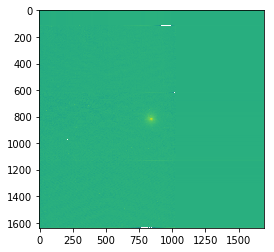

In [160]:
# Define data to calculate from 
data = fits.open('/Users/jessicaschonhut/flares_paper/keck_obs/calibrated/9944137/h/pad_test_reduced/final_stacked_9944137_h.fits')
data = data[0].data
plt.imshow(data)
data = np.nan_to_num(data, copy=False, nan=np.nanmean(data))

# Set coordinares for primary and secondary star and set total magnitude from the system (KASOC)
primary = (845.51, 819.08)
secondary = (281.76, 882.29)
total_mag = 12.335

In [186]:
# Set up radii and background annuli for aperture photometry 
r = 16
positions = [primary, secondary]
aperture = CircularAperture(positions, r) # Aperture for stars 
print(type(aperture))
annulus_aperture = CircularAnnulus(positions, r_in=r+114, r_out=r+129) # Aperture for background calculation
apers = [aperture, annulus_aperture]

# Sum the inside of the apertures for the primary and secondary star
phot_table = aperture_photometry(data, apers, method='subpixel', subpixels=5)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

<class 'photutils.aperture.circle.CircularAperture'>
 id xcenter ycenter aperture_sum_0 aperture_sum_1
      pix     pix                                
--- ------- ------- -------------- --------------
  1  845.51  819.08      3115.0371      35012.684
  2  281.76  882.29      2179.6945       34574.16


In [187]:
# Determine the value of the background from the surrounding annuli
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area()
print(bkg_mean)
bkg_sum = bkg_mean * aperture.area()
print(bkg_sum)

aperture_sum_1
--------------
       2.70179
     2.6679508
aperture_sum_1
--------------
     2172.9084
     2145.6933


In [188]:
# Determine aperture photometry values corrected for the background
final_sum = phot_table['aperture_sum_0'] - bkg_sum
phot_table['residual_aperture_sum'] = final_sum
final_sum_error = np.sqrt(final_sum) / final_sum
print(final_sum_error)

aperture_sum_0
--------------
   0.032579536
    0.17149559


In [189]:
# Calculate the flux ratio between the secondary and primary star (F_2/F_1)
flux_rat = final_sum[1] / final_sum[0]
flux_rat_err = flux_rat * np.sqrt((final_sum_error[1]/final_sum[1])**2 + (final_sum_error[0]/final_sum[0])**2) 
print(flux_rat)
print(flux_rat_err)

0.03608975014252076
0.00018203418397969926


In [190]:
# Print the calculations and the magnitude difference
total_flux = (10**(-(total_mag/2.5)))

p_flux = total_flux / (flux_rat + 1) 
p_flux_err = (float(total_flux) / ((flux_rat + 1)**2)) * flux_rat_err
print("Flux of the primary: " + str(p_flux) + ', ' + str(p_flux_err))     
    
s_flux = flux_rat * p_flux
s_flux_err = np.sqrt((p_flux * flux_rat_err)**2 + (flux_rat * p_flux_err)**2)
print("Flux of secondary: " + str(s_flux) + ', ' + str(s_flux_err))

p_mag = -2.5 * (np.log10(p_flux))
p_mag_err = (2.5 * p_flux_err) / float(p_flux * np.log(10))
print("Magnitude of the primary: " + str(p_mag) + ', ' + str(p_mag_err))

s_mag = -2.5 * (np.log10(s_flux))
s_mag_err = (2.5 * s_flux_err) / float(s_flux * np.log(10))
print("Magnitude of the secondary: " + str(s_mag) + ', ' + str(s_mag_err))
    
mag_diff = s_mag - p_mag
mag_diff_err = np.sqrt((s_mag_err)**2 + (p_mag_err)**2)
print("Magnitude Difference: " + str(mag_diff) + ', ' + str(mag_diff_err))

Flux of the primary: 1.1235764365493992e-05, 1.9740502185062044e-09
Flux of secondary: 4.054959286109165e-07, 2.0465336123496017e-09
Magnitude of the primary: 12.373493443309195, 0.00019075674093211998
Magnitude of the secondary: 15.98003375493101, 0.005479699006582288
Magnitude Difference: 3.6065403116218153, 0.0054830182688871245
